# Read NHTSA API, Merge with Weather Data, & Format/Explore

#### Project Members: Ming Gao, Monica Moussavi, Joey Picca, Rohan Kancharla

This notebook reads fatal accident data from the NHTSA's API and formats this data such that it can be merged with weather datasets. This way, we can investigate changes in accident rates across different levels of precipitation.

In [1]:
import requests
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Set up API request

In [2]:
base_url = 'https://crashviewer.nhtsa.dot.gov/CrashAPI/crashes/GetCaseList?'

In [3]:
params = {
    'states':'42',
    'fromYear':'2014',
    'toYear':'2014',
    'minNumOfVehicles':'1',
    'maxNumOfVehicles':'20',
    'format':'json'
}

### Make API requests
Note: This is performed for every state, using the state code, we wish to query for accident info.
In our case, that's New York (36), California (6), Illinois (17), Texas (48), Arizona (4), and Pennsylvania (42)

In [4]:
# We need to loop through years to reduce the number of returns from the API call
states = ['36','6','17','48','4','42']
years = ['2014','2015','2016','2017','2018']

counties, date, deaths, caseNum, vehicleNum = [],[],[],[],[]

for state in states:
    params['states'] = state
    for year in years:
        params['fromYear'] = year
        params['toYear'] = year

        response = requests.get(base_url,params=params)

        crashList = response.json()['Results'][0]

        # Loop through the accident list in the returned json and append accident details to our list
        for crash in crashList:

            counties.append(crash["CountyName"])
            date.append(crash['CrashDate'])
            deaths.append(crash['Fatals'])
            caseNum.append(crash['St_Case'])
            vehicleNum.append(crash['TotalVehicles'])

### Format dataframes for each city/county combo

In [5]:
# Use the previously created lists to create a dataframe
df = pd.DataFrame({'County':counties,'Date':date,'Deaths':deaths,'Case':caseNum,'Vehicles':vehicleNum})

In [6]:
# For each state, make a dataframe using the county of interest for our selected cities in that state
# 
# Texas: Dallas (Dallas Co), Houston (Harris Co), San Antonio (Bexar Co)
# New York: New York City (New York Co, Richmond Co, Kings Co, Queens Co, Bronx Co)
# California: Los Angeles (Los Angeles Co), San Jose (Santa Clara Co), San Diego (San Diego Co)
# Illinois: Chicago (Cook Co)
# Arizona: Phoenix (Maricopa Co)
# Pennsylvania: Philadelphia (Philadelphia Co)

dfPA = df[(df['County'] == 'PHILADELPHIA (101)')]
dfTX = df[(df['County'] == 'DALLAS (113)') | (df['County'] == 'HARRIS (201)') |
         (df['County'] == 'BEXAR (29)')]
dfNY = df[(df['County'] == 'QUEENS (81)') | (df['County'] == 'RICHMOND (85)') |
         (df['County'] == 'KINGS (47)') | (df['County'] == 'BRONX (5)') |
         (df['County'] == 'NEW YORK (61)')]
dfCA = df[(df['County'] == 'LOS ANGELES (37)') | (df['County'] == 'SAN DIEGO (73)') |
         (df['County'] == 'SANTA CLARA (85)')]
dfAZ = df[(df['County'] == 'MARICOPA (13)')]
dfIL = df[(df['County'] == 'COOK (31)')]

In [7]:
# Example of the accident dataframe for Philadelphia
dfPA.head()

,County,Date,Deaths,Case,Vehicles
46607,PHILADELPHIA (101),/Date(1390794300000-0500)/,1,420031,1
46608,PHILADELPHIA (101),/Date(1389050280000-0500)/,1,420032,1
46640,PHILADELPHIA (101),/Date(1391352360000-0500)/,1,420064,1
46647,PHILADELPHIA (101),/Date(1393044420000-0500)/,1,420071,1
46650,PHILADELPHIA (101),/Date(1392714180000-0500)/,1,420074,2


In [8]:
# Since we pulled only specific counties from the original state dataframe, let's clean up the index
dfPA = dfPA.reset_index(drop = True)
dfTX = dfTX.reset_index(drop = True)
dfCA = dfCA.reset_index(drop = True)
dfNY = dfNY.reset_index(drop = True)
dfAZ = dfAZ.reset_index(drop = True)
dfIL = dfIL.reset_index(drop = True)

In [9]:
# Use a for loop to loop through the rows of the dataframe and change the date column to something merge-able
# with our weather data. It was discovered during date conversion that a few dates are misformatted in the API.
# Thus, we had to change from using a map(lambda x: ...) to a try and except to catch returned errors.
def dateCleaner(df):
    for index, row in df.iterrows():

        try:

            df.loc[index,'Date'] = datetime.fromtimestamp((int(row['Date'].split('-')[0][6:])+3600000)/1000).strftime('%Y-%m-%d')

        except:

            df.loc[index,'Date'] = np.nan

In [10]:
# Run the date cleaner on our dataframes
dateCleaner(dfPA)
dateCleaner(dfTX)
dateCleaner(dfNY)
dateCleaner(dfCA)
dateCleaner(dfIL)
dateCleaner(dfAZ)

In [11]:
# The date has been converted to a friendlier format
dfTX.head()

,County,Date,Deaths,Case,Vehicles
0,BEXAR (29),2014-01-01,1,480001,2
1,DALLAS (113),2014-01-01,1,480002,1
2,DALLAS (113),2014-01-01,2,480003,2
3,HARRIS (201),2014-01-01,1,480006,2
4,HARRIS (201),2014-01-01,1,480007,1


In [12]:
# Read in our weather datasets that were compiled from: http://xmacis.rcc-acis.org/

dalWx = pd.read_csv('./data/clean/dfwClean.csv')
nycWx = pd.read_csv('./data/clean/nycClean.csv')
laWx = pd.read_csv('./data/clean/laClean.csv')
chiWx = pd.read_csv('./data/clean/chiClean.csv')
houWx = pd.read_csv('./data/clean/houClean.csv')
phxWx = pd.read_csv('./data/clean/phxClean.csv')
phlWx = pd.read_csv('./data/clean/phlClean.csv')
sdWx = pd.read_csv('./data/clean/sdClean.csv')
sjWx = pd.read_csv('./data/clean/sjClean.csv')
saWx = pd.read_csv('./data/clean/saClean.csv')

#### Merge weather data with accident data for our individual cities/counties
- Note: If we haven't already pulled the specific county rows from the state dataframe, we do so now. Also, we add a "City" column so that when we merge all of these dataframes into a master df, we associate each row to a specific city.

- Second note: We perform a left merge with the weather dataframe as the left df. We want to keep every date, accident or not.

##### Dallas

In [13]:
dfdal = dfTX[dfTX['County'] == 'DALLAS (113)']

In [14]:
dalMerged = pd.merge(dalWx,dfdal,on='Date',how='left')
dalMerged.loc[:,'City'] = 'Dallas'
dalMerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,69,31,0.0,DALLAS (113),1.0,480002.0,1.0,Dallas
1,2014-01-01,69,31,0.0,DALLAS (113),2.0,480003.0,2.0,Dallas
2,2014-01-01,69,31,0.0,DALLAS (113),1.0,480182.0,2.0,Dallas
3,2014-01-02,43,25,0.0,NaN,NaN,NaN,NaN,Dallas
4,2014-01-03,52,25,0.0,NaN,NaN,NaN,NaN,Dallas


##### NYC

In [15]:
nycmerged = pd.merge(nycWx,dfNY,on='Date',how='left')
nycmerged.loc[:,'City'] = 'New York City'
nycmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,33,24,0.00,QUEENS (81),1.0,360002.0,1.0,New York City
1,2014-01-01,33,24,0.00,RICHMOND (85),1.0,360007.0,3.0,New York City
2,2014-01-02,33,18,0.33,QUEENS (81),1.0,360005.0,2.0,New York City
3,2014-01-02,33,18,0.33,KINGS (47),1.0,360006.0,2.0,New York City
4,2014-01-02,33,18,0.33,BRONX (5),1.0,360820.0,1.0,New York City


##### LA

In [16]:
dfla = dfCA[dfCA['County'] == 'LOS ANGELES (37)']

In [17]:
lamerged = pd.merge(laWx,dfla,on='Date',how='left')
lamerged.loc[:,'City'] = 'Los Angeles'
lamerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,64,46,0.0,NaN,NaN,NaN,NaN,Los Angeles
1,2014-01-02,78,50,0.0,LOS ANGELES (37),1.0,60012.0,1.0,Los Angeles
2,2014-01-02,78,50,0.0,LOS ANGELES (37),1.0,60032.0,2.0,Los Angeles
3,2014-01-02,78,50,0.0,LOS ANGELES (37),1.0,62670.0,1.0,Los Angeles
4,2014-01-03,64,47,0.0,LOS ANGELES (37),1.0,60017.0,1.0,Los Angeles


##### Chicago

In [18]:
chimerged = pd.merge(chiWx,dfIL,on='Date',how='left')
chimerged.loc[:,'City'] = 'Chicago'
chimerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,22,10,0.25,COOK (31),3.0,170111.0,1.0,Chicago
1,2014-01-02,21,-1,0.22,NaN,NaN,NaN,NaN,Chicago
2,2014-01-03,20,-12,0.00,NaN,NaN,NaN,NaN,Chicago
3,2014-01-04,31,19,0.26,NaN,NaN,NaN,NaN,Chicago
4,2014-01-05,29,-3,0.59,NaN,NaN,NaN,NaN,Chicago


##### Houston

In [19]:
dfhou = dfTX[dfTX['County'] == 'HARRIS (201)']

In [20]:
houmerged = pd.merge(houWx,dfhou,on='Date',how='left')
houmerged.loc[:,'City'] = 'Houston'
houmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,65,46,0.001,HARRIS (201),1.0,480006.0,2.0,Houston
1,2014-01-01,65,46,0.001,HARRIS (201),1.0,480007.0,1.0,Houston
2,2014-01-01,65,46,0.001,HARRIS (201),1.0,480008.0,1.0,Houston
3,2014-01-01,65,46,0.001,HARRIS (201),1.0,480100.0,1.0,Houston
4,2014-01-01,65,46,0.001,HARRIS (201),1.0,480101.0,3.0,Houston


##### Phoenix

In [21]:
phxmerged = pd.merge(phxWx,dfAZ,on='Date',how='left')
phxmerged.loc[:,'City'] = 'Phoenix'
phxmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,70,43,0.0,MARICOPA (13),1.0,40019.0,1.0,Phoenix
1,2014-01-01,70,43,0.0,MARICOPA (13),1.0,40050.0,2.0,Phoenix
2,2014-01-02,77,44,0.0,MARICOPA (13),1.0,40051.0,1.0,Phoenix
3,2014-01-03,74,48,0.0,NaN,NaN,NaN,NaN,Phoenix
4,2014-01-04,68,48,0.0,MARICOPA (13),1.0,40052.0,2.0,Phoenix


##### Philadelphia

In [22]:
phlmerged = pd.merge(phlWx,dfPA,on='Date',how='left')
phlmerged.loc[:,'City'] = 'Philadelphia'
phlmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,41,23,0.00,NaN,NaN,NaN,NaN,Philadelphia
1,2014-01-02,35,22,0.40,NaN,NaN,NaN,NaN,Philadelphia
2,2014-01-03,22,11,0.30,NaN,NaN,NaN,NaN,Philadelphia
3,2014-01-04,29,8,0.00,NaN,NaN,NaN,NaN,Philadelphia
4,2014-01-05,53,18,0.18,NaN,NaN,NaN,NaN,Philadelphia


##### San Diego

In [23]:
dfsd = dfCA[dfCA['County'] == 'SAN DIEGO (73)']

In [24]:
sdmerged = pd.merge(sdWx,dfsd,on='Date',how='left')
sdmerged.loc[:,'City'] = 'San Diego'
sdmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,68,47,0.0,NaN,NaN,NaN,NaN,San Diego
1,2014-01-02,71,47,0.0,NaN,NaN,NaN,NaN,San Diego
2,2014-01-03,66,46,0.0,SAN DIEGO (73),1.0,60016.0,1.0,San Diego
3,2014-01-03,66,46,0.0,SAN DIEGO (73),1.0,60042.0,1.0,San Diego
4,2014-01-04,66,56,0.0,NaN,NaN,NaN,NaN,San Diego


##### San Jose

In [25]:
dfsj = dfCA[dfCA['County'] == 'SANTA CLARA (85)']

In [26]:
sjmerged = pd.merge(sjWx,dfsj,on='Date',how='left')
sjmerged.loc[:,'City'] = 'San Jose'
sjmerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,62,35,0.0,NaN,NaN,NaN,NaN,San Jose
1,2014-01-02,65,38,0.0,NaN,NaN,NaN,NaN,San Jose
2,2014-01-03,64,40,0.0,NaN,NaN,NaN,NaN,San Jose
3,2014-01-04,66,38,0.0,NaN,NaN,NaN,NaN,San Jose
4,2014-01-05,66,35,0.0,SANTA CLARA (85),1.0,60640.0,2.0,San Jose


##### San Antonio

In [27]:
dfsa = dfTX[dfTX['County'] == 'BEXAR (29)']

In [28]:
samerged = pd.merge(saWx,dfsa,on='Date',how='left')
samerged.loc[:,'City'] = 'San Antonio'
samerged.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City
0,2014-01-01,61,39,0.0,BEXAR (29),1.0,480001.0,2.0,San Antonio
1,2014-01-02,57,35,0.0,NaN,NaN,NaN,NaN,San Antonio
2,2014-01-03,57,28,0.0,BEXAR (29),1.0,480019.0,1.0,San Antonio
3,2014-01-04,71,46,0.0,NaN,NaN,NaN,NaN,San Antonio
4,2014-01-05,58,38,0.0,BEXAR (29),1.0,480039.0,1.0,San Antonio


### Create a master df holding all cities

In [29]:
masterDF = pd.concat([dalMerged,samerged,houmerged,sjmerged,lamerged,sdmerged,nycmerged,phlmerged,chimerged,phxmerged])

In [30]:
# Reset the index to clean up
masterDF.reset_index(drop=True,inplace=True)

To get an idea of different levels of precipitation, we return a dataframe with just precipitation days. We can use this to find good breakpoints for levels of precipitation.

In [31]:
precipDF = masterDF[masterDF['Precipitation'] > 0.001]

In [32]:
print(f"25th Percentile of Precipitation: {precipDF.quantile(0.25)['Precipitation']}") 
print(f"75th Percentile of Precipitation: {precipDF.quantile(0.75)['Precipitation']}")
print(f"95th Percentile of Precipitation: {precipDF.quantile(0.95)['Precipitation']}")

25th Percentile of Precipitation: 0.04
75th Percentile of Precipitation: 0.48
95th Percentile of Precipitation: 1.54


Using the above information, we decided to bin precipitation levels into the following categories.
 - Dry: 0.00"
 - Light: 0.001" - 0.04"
 - Moderate: 0.05" - 0.49"
 - Heavy: 0.50" - 1.49"
 - Very Heavy: 1.5"+


In [33]:
masterDF['Category'] = pd.cut(masterDF['Precipitation'],[-0.001,0.00,0.04,0.49,1.49,25.0],
                              labels=['Dry','Light','Moderate','Heavy','Very Heavy'])

In [34]:
# Save our master df to a csv
# masterDF.to_csv('./data/clean/allCitiesAndWeather.csv')

### Load the old csv if we don't want to re-create the dataframe

In [35]:
masterDF = pd.read_csv('./data/clean/allCitiesAndWeather.csv',index_col=0)

In [36]:
masterDF.head()

,Date,MaxTemp,MinTemp,Precipitation,County,Deaths,Case,Vehicles,City,Category
0,2014-01-01,69,31,0.0,DALLAS (113),1.0,480002.0,1.0,Dallas,Dry
1,2014-01-01,69,31,0.0,DALLAS (113),2.0,480003.0,2.0,Dallas,Dry
2,2014-01-01,69,31,0.0,DALLAS (113),1.0,480182.0,2.0,Dallas,Dry
3,2014-01-02,43,25,0.0,NaN,NaN,NaN,NaN,Dallas,Dry
4,2014-01-03,52,25,0.0,NaN,NaN,NaN,NaN,Dallas,Dry


## Exploratory/Initial Analysis

##### Total Rainfall by City

In [37]:
totalRain = precipDF.groupby('City')['Precipitation'].sum()

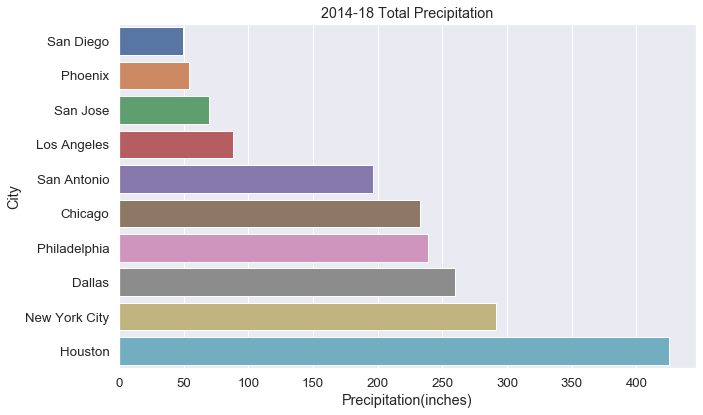

In [38]:
totalRain_sort=totalRain.sort_values()
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
ax=sns.barplot(x=totalRain_sort,y=totalRain_sort.index.values)
ax.set(xlabel="Precipitation(inches)", ylabel="City", title="2014-18 Total Precipitation")
plt.tight_layout()
plt.savefig('./images/totalPrecip.png',dpi=300)
plt.show()

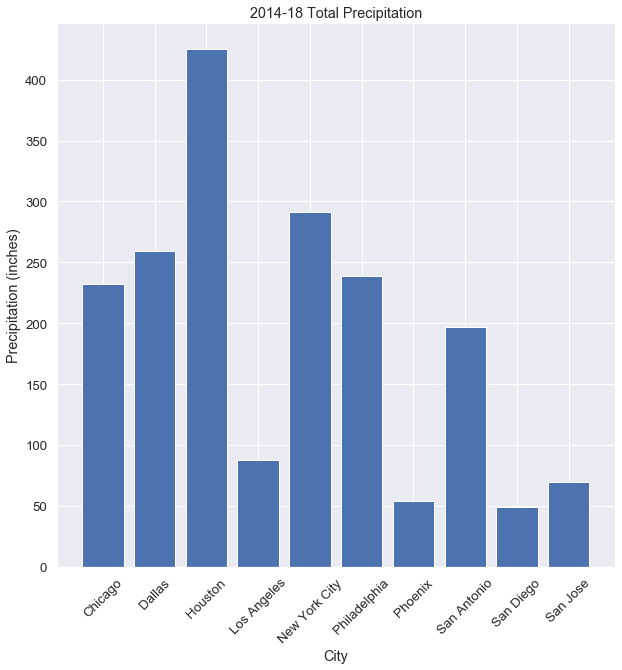

In [39]:
#totalRain.keys()

fig,ax = plt.subplots(1,1,figsize=(10,10))
plt.bar(np.arange(0,10),totalRain.values,tick_label=totalRain.keys())
plt.xticks(rotation=45)
plt.title('2014-18 Total Precipitation')
plt.ylabel('Precipitation (inches)')
plt.xlabel('City')
plt.savefig('./images/totalPrecip.png',dpi=300)
plt.show()

Based on the above bar chart, our cities cluster into two groups:
 - "Accustomed to Precipitation": New York City, Chicago, Houston, Philadelphia, Dallas, San Antonio
 - "Not Accustomed to Precipitation": Los Angeles, San Jose, San Diego, Phoenix

### Relative Frequency of Accidents by Precipitation Category
Analyze the relative frequency of precipitation category associated with each accident. 

In [40]:
onlyAccidents = masterDF[masterDF['Case'].notna()]

In [41]:
accidentByCat = onlyAccidents.groupby('Category')['Case'].count()

In [42]:
accidentByCat.keys()

Index(['Dry', 'Heavy', 'Light', 'Moderate', 'Very Heavy'], dtype='object', name='Category')

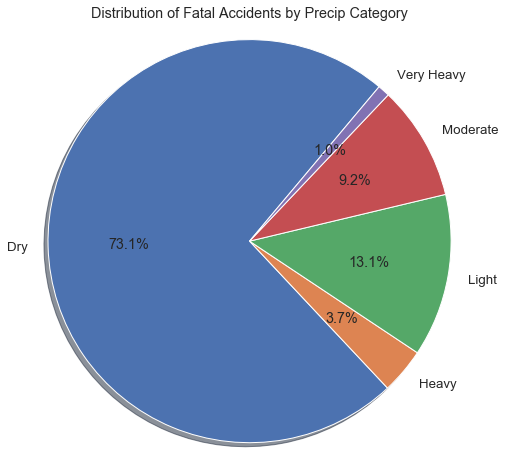

In [43]:
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(accidentByCat.values, autopct='%1.1f%%', labels=accidentByCat.keys(),
        shadow=True, startangle=50)
ax1.axis('equal')
plt.title('Distribution of Fatal Accidents by Precip Category')
plt.savefig('./images/pieDistribution.png',dpi=300)
plt.show()

### Fatal Accident Rate Per Day
Broken down by precipitation category, plot accident rate per day for all cities combined.

In [44]:
# Get the number of precip type days for each city and then sum them

countDal = masterDF[masterDF['City'] == 'Dallas'].groupby('Category')['Date'].count()
countNYC = masterDF[masterDF['City'] == 'New York City'].groupby('Category')['Date'].count()
countLA = masterDF[masterDF['City'] == 'Los Angeles'].groupby('Category')['Date'].count()
countHou = masterDF[masterDF['City'] == 'Houston'].groupby('Category')['Date'].count()
countPhx = masterDF[masterDF['City'] == 'Phoenix'].groupby('Category')['Date'].count()
countChi = masterDF[masterDF['City'] == 'Chicago'].groupby('Category')['Date'].count()
countPhi = masterDF[masterDF['City'] == 'Philadelphia'].groupby('Category')['Date'].count()
countSJ = masterDF[masterDF['City'] == 'San Jose'].groupby('Category')['Date'].count()
countSD = masterDF[masterDF['City'] == 'San Diego'].groupby('Category')['Date'].count()
countSA = masterDF[masterDF['City'] == 'San Antonio'].groupby('Category')['Date'].count()

totalByCat = countDal+countNYC+countLA+countHou+countPhx+countChi+countPhi+countSJ+countSD+countSA

In [45]:
ratesByCat = masterDF.groupby('Category')['Case'].count()/totalByCat

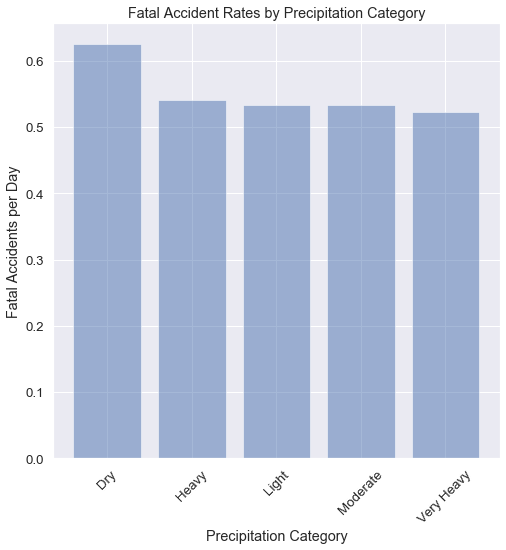

In [46]:
fig,ax = plt.subplots(figsize=(8,8))
plt.bar(np.arange(0,5),ratesByCat,tick_label=ratesByCat.keys(),alpha=0.5)
plt.xticks(rotation=45)
plt.title('Fatal Accident Rates by Precipitation Category')
plt.ylabel('Fatal Accidents per Day')
plt.xlabel('Precipitation Category')
plt.savefig('./images/ratesPerDayAllCities.png',dpi=300)
plt.show()